In [11]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [12]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/plant_village_datatset/archive (7)/PlantVillage/'


In [13]:
import os

print(os.listdir(dataset_path))



['Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_Septoria_leaf_spot', 'Tomato__Target_Spot', 'Tomato_Leaf_Mold', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Late_blight', 'Tomato_Early_blight', 'Tomato_Bacterial_spot', 'Tomato_healthy', 'Potato___healthy', 'Potato___Late_blight', 'Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight']


In [14]:
!cp -r "/content/drive/MyDrive/Colab Notebooks/plant_village_datatset/archive (7)/PlantVillage/" /content/
dataset_path = "/content/PlantVillage/"



In [15]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
import os
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator




In [16]:
original_dir = "/content/PlantVillage/"
test_dir = "/content/PlantVillage_test/"

os.makedirs(test_dir, exist_ok=True)


In [17]:
for class_name in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)
    n_test = int(0.1 * len(images))  # 10% of images

    test_images = images[:n_test]

    # create class folder in test_dir
    test_class_dir = os.path.join(test_dir, class_name)
    os.makedirs(test_class_dir, exist_ok=True)

    # move images to test folder
    for img in test_images:
        shutil.move(os.path.join(class_path, img), os.path.join(test_class_dir, img))


In [18]:
img_size = (224, 224)
batch_size = 32

# Train + Validation
train_val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.125  # ~12.5% of remaining images for validation
)

train_generator = train_val_datagen.flow_from_directory(
    original_dir,
    target_size=img_size,
    batch_size=batch_size,
    subset='training',
    color_mode='rgb'
)

val_generator = train_val_datagen.flow_from_directory(
    original_dir,
    target_size=img_size,
    batch_size=batch_size,
    subset='validation',
    color_mode='rgb'
)

# Test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=False
)



Found 16262 images belonging to 15 classes.
Found 2318 images belonging to 15 classes.
Found 2058 images belonging to 15 classes.


In [19]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# Load pretrained MobileNetV2 without top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze base layers for feature extraction

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Complete model
model = Model(inputs=base_model.input, outputs=predictions)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15
)



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5749 - loss: 1.3611

In [18]:
# Unfreeze last 50 layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15
)



NameError: name 'base_model' is not defined

In [ ]:
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")



65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - accuracy: 0.9293 - loss: 0.2038
Test Accuracy: 91.21%


In [17]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Fine-Tuned Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history_finetune.history['loss'], label='Train Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.title('Fine-Tuned Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


NameError: name 'history_finetune' is not defined

In [ ]:
model.save('/content/plant_disease_mobilenet_color.h5')
# Optional: copy to Drive
!cp /content/plant_disease_mobilenet_color.h5 "/content/drive/MyDrive/Colab Notebooks/"


In [ ]:
from google.colab import drive
drive.flush_and_unmount()




Drive not mounted, so nothing to flush and unmount.


In [ ]:
!fusermount -u /content/drive


fusermount: failed to unmount /content/drive: Invalid argument


In [ ]:
!rm -rf /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import shutil
import os

local_base = "/content/PlantVillage/"

# Delete mistakenly included folders
shutil.rmtree(os.path.join(local_base, "PlantVillage_Gray"), ignore_errors=True)
shutil.rmtree(os.path.join(local_base, "PlantVillage_Segmented"), ignore_errors=True)

print("Deleted erroneous folders inside local_base")


Deleted erroneous folders inside local_base


In [ ]:
from google.colab import drive
drive.flush_and_unmount()
print("Drive unmounted successfully.")


Drive not mounted, so nothing to flush and unmount.
Drive unmounted successfully.


In [ ]:
# -------------------------------
# Step 0: Mount Google Drive
# -------------------------------
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# -------------------------------
# Step 1: Import libraries
# -------------------------------
import os
import shutil
import cv2
from tqdm import tqdm

# -------------------------------
# Step 2: Define paths
# -------------------------------
# Original dataset in Drive
original_dir = "/content/drive/MyDrive/Colab Notebooks/plant_village_datatset/archive (7)/PlantVillage/"

# Local directories for fast processing
local_base = "/content/PlantVillage/"
gray_dir = os.path.join(local_base, "PlantVillage_Gray")
segmented_dir = os.path.join(local_base, "PlantVillage_Segmented")

# Remove old output dirs if they exist
shutil.rmtree(gray_dir, ignore_errors=True)
shutil.rmtree(segmented_dir, ignore_errors=True)

# Make fresh output dirs
os.makedirs(gray_dir, exist_ok=True)
os.makedirs(segmented_dir, exist_ok=True)

# -------------------------------
# Step 3: Copy original dataset to /content/
# -------------------------------
for class_name in os.listdir(original_dir):
    src = os.path.join(original_dir, class_name)
    dst = os.path.join(local_base, class_name)
    if os.path.isdir(src):
        shutil.copytree(src, dst, dirs_exist_ok=True)

# -------------------------------
# Step 4: Preprocess images
# -------------------------------
output_dirs = ["PlantVillage_Gray", "PlantVillage_Segmented"]

for class_name in tqdm(os.listdir(local_base), desc="Processing classes"):
    if class_name in output_dirs:
        continue  # skip output folders

    class_path = os.path.join(local_base, class_name)
    if not os.path.isdir(class_path):
        continue

    # Create class folders in output directories
    os.makedirs(os.path.join(gray_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(segmented_dir, class_name), exist_ok=True)

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue

        # ---------- Grayscale ----------
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        cv2.imwrite(os.path.join(gray_dir, class_name, img_name), gray)

        # ---------- Segmentation (green leaf mask) ----------
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        lower = (25, 40, 40)
        upper = (85, 255, 255)
        mask = cv2.inRange(hsv, lower, upper)
        result = cv2.bitwise_and(img, img, mask=mask)
        cv2.imwrite(os.path.join(segmented_dir, class_name, img_name), result)

# -------------------------------
# Step 5: Verify classes
# -------------------------------
print("Grayscale classes:", sorted(os.listdir(gray_dir)))
print("Segmented classes:", sorted(os.listdir(segmented_dir)))

# -------------------------------
# Step 6: Copy processed datasets back to Drive
# -------------------------------
drive_base = "/content/drive/MyDrive/Colab Notebooks/plant_village_datatset/"

shutil.copytree(gray_dir, os.path.join(drive_base, "PlantVillage_Gray"), dirs_exist_ok=True)
shutil.copytree(segmented_dir, os.path.join(drive_base, "PlantVillage_Segmented"), dirs_exist_ok=True)

print("✅ Preprocessing complete! Grayscale and segmented datasets are ready in /content/ and Drive.")


Mounted at /content/drive


Processing classes: 100%|██████████| 17/17 [00:50<00:00,  2.97s/it]


Grayscale classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Segmented classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
✅ Preprocessing complete! Grayscale and segmented datasets are ready in /content/ and Drive.


In [ ]:
import os

gray_dir = "/content/drive/MyDrive/Colab Notebooks/plant_village_datatset/PlantVillage_Gray"
segmented_dir = "/content/drive/MyDrive/Colab Notebooks/plant_village_datatset/PlantVillage_Segmented"

print("Grayscale classes:", sorted(os.listdir(gray_dir)))
print("Segmented classes:", sorted(os.listdir(segmented_dir)))

print("Number of Grayscale classes:", len(os.listdir(gray_dir)))
print("Number of Segmented classes:", len(os.listdir(segmented_dir)))



Grayscale classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Segmented classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Number of Grayscale classes: 15
Number of Segmented classes: 15


In [ ]:
for class_name in sorted(os.listdir(gray_dir)):
    class_path = os.path.join(gray_dir, class_name)
    num_images = len(os.listdir(class_path))
    print(f"Grayscale - {class_name}: {num_images} images")

for class_name in sorted(os.listdir(segmented_dir)):
    class_path = os.path.join(segmented_dir, class_name)
    num_images = len(os.listdir(class_path))
    print(f"Segmented - {class_name}: {num_images} images")


Grayscale - Pepper__bell___Bacterial_spot: 997 images
Grayscale - Pepper__bell___healthy: 1478 images
Grayscale - Potato___Early_blight: 1000 images
Grayscale - Potato___Late_blight: 1000 images
Grayscale - Potato___healthy: 152 images
Grayscale - Tomato_Bacterial_spot: 2127 images
Grayscale - Tomato_Early_blight: 1000 images
Grayscale - Tomato_Late_blight: 1909 images
Grayscale - Tomato_Leaf_Mold: 952 images
Grayscale - Tomato_Septoria_leaf_spot: 1771 images
Grayscale - Tomato_Spider_mites_Two_spotted_spider_mite: 1676 images
Grayscale - Tomato__Target_Spot: 1404 images
Grayscale - Tomato__Tomato_YellowLeaf__Curl_Virus: 3208 images
Grayscale - Tomato__Tomato_mosaic_virus: 373 images
Grayscale - Tomato_healthy: 1591 images
Segmented - Pepper__bell___Bacterial_spot: 997 images
Segmented - Pepper__bell___healthy: 1478 images
Segmented - Potato___Early_blight: 1000 images
Segmented - Potato___Late_blight: 1000 images
Segmented - Potato___healthy: 152 images
Segmented - Tomato_Bacterial_sp

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
print("Drive unmounted successfully.")


Drive not mounted, so nothing to flush and unmount.
Drive unmounted successfully.


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp -r "/content/drive/MyDrive/Colab Notebooks/plant_village_datatset/PlantVillage_Gray" "/content/"
!cp -r "/content/drive/MyDrive/Colab Notebooks/plant_village_datatset/PlantVillage_Segmented" "/content/"


In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# =============================
# 1️⃣ Dataset paths & preprocessing
# =============================
gray_dir = "/content/PlantVillage_Gray"

train_datagen_gray = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator_gray = train_datagen_gray.flow_from_directory(
    gray_dir,
    target_size=(224, 224),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator_gray = train_datagen_gray.flow_from_directory(
    gray_dir,
    target_size=(224, 224),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# =============================
# 2️⃣ Base Model Setup (MobileNetV2)
# =============================
base_model_gray = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model_gray.trainable = False  # freeze initial layers

# Convert grayscale input (1 channel → 3 channel)
inputs_gray = Input(shape=(224,224,1))
x = Concatenate()([inputs_gray, inputs_gray, inputs_gray])
x = base_model_gray(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions_gray = Dense(train_generator_gray.num_classes, activation='softmax')(x)

model_gray = Model(inputs=inputs_gray, outputs=predictions_gray)

# =============================
# 3️⃣ Compile & Train (Feature Extraction)
# =============================
model_gray.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_gray = model_gray.fit(
    train_generator_gray,
    validation_data=val_generator_gray,
    epochs=15
)

# =============================
# 4️⃣ Fine-Tuning
# =============================
base_model_gray.trainable = True
for layer in base_model_gray.layers[:-50]:
    layer.trainable = False

model_gray.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune_gray = model_gray.fit(
    train_generator_gray,
    validation_data=val_generator_gray,
    epochs=15
)


Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


517/517 ━━━━━━━━━━━━━━━━━━━━ 74s 104ms/step - accuracy: 0.6038 - loss: 1.2690 - val_accuracy: 0.8246 - val_loss: 0.5161
Epoch 2/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step - accuracy: 0.8074 - loss: 0.5730 - val_accuracy: 0.8525 - val_loss: 0.4307
Epoch 3/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step - accuracy: 0.8441 - loss: 0.4595 - val_accuracy: 0.8683 - val_loss: 0.3960
Epoch 4/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 31s 60ms/step - accuracy: 0.8634 - loss: 0.4025 - val_accuracy: 0.8707 - val_loss: 0.3620
Epoch 5/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 26s 50ms/step - accuracy: 0.8706 - loss: 0.3780 - val_accuracy: 0.8726 - val_loss: 0.3663
Epoch 6/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 26s 50ms/step - accuracy: 0.8814 - loss: 0.3489 - val_accuracy: 0.8729 - val_loss: 0.3828
Epoch 7/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step - accuracy: 0.8929 - loss: 0.3073 - val_accuracy: 0.8794 - val_loss: 0.3502
Epoch 8/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 26s 50ms/step - accuracy: 0.9023 - loss: 0.2794 - val_accura

In [13]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# =============================
# 1️⃣ Dataset paths & preprocessing
# =============================
seg_dir = "/content/PlantVillage_Segmented"

train_datagen_seg = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator_seg = train_datagen_seg.flow_from_directory(
    seg_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator_seg = train_datagen_seg.flow_from_directory(
    seg_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# =============================
# 2️⃣ Base Model Setup (MobileNetV2)
# =============================
base_model_seg = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model_seg.trainable = False  # freeze initial layers

inputs_seg = Input(shape=(224,224,3))
x = base_model_seg(inputs_seg, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions_seg = Dense(train_generator_seg.num_classes, activation='softmax')(x)

model_seg = Model(inputs=inputs_seg, outputs=predictions_seg)

# =============================
# 3️⃣ Compile & Train (Feature Extraction)
# =============================
model_seg.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_seg = model_seg.fit(
    train_generator_seg,
    validation_data=val_generator_seg,
    epochs=15
)

# =============================
# 4️⃣ Fine-Tuning
# =============================
base_model_seg.trainable = True
for layer in base_model_seg.layers[:-50]:
    layer.trainable = False

model_seg.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune_seg = model_seg.fit(
    train_generator_seg,
    validation_data=val_generator_seg,
    epochs=15
)


Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
Epoch 1/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 56s 91ms/step - accuracy: 0.6157 - loss: 1.2117 - val_accuracy: 0.8358 - val_loss: 0.4826
Epoch 2/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 33s 64ms/step - accuracy: 0.8303 - loss: 0.5144 - val_accuracy: 0.8792 - val_loss: 0.3657
Epoch 3/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 35s 68ms/step - accuracy: 0.8611 - loss: 0.4079 - val_accuracy: 0.8738 - val_loss: 0.3662
Epoch 4/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - accuracy: 0.8803 - loss: 0.3588 - val_accuracy: 0.8954 - val_loss: 0.3156
Epoch 5/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - accuracy: 0.8912 - loss: 0.3163 - val_accuracy: 0.8935 - val_loss: 0.3064
Epoch 6/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 34s 65ms/step - accuracy: 0.9021 - loss: 0.2861 - val_accuracy: 0.8976 - val_loss: 0.2888
Epoch 7/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.9018 - loss: 0.2746 - val_accuracy: 0.9030 - val_loss: 0.2854
Epo

In [14]:
!cp -r "/content/drive/MyDrive/Colab Notebooks/plant_village_datatset/archive (7)/PlantVillage/" /content/
dataset_path = "/content/PlantVillage/"

In [7]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!ls "/content/drive/MyDrive/Colab Notebooks"



'ML PROJECT SHEET.ipynb'	    plant_village_datatset
 plant_disease_mobilenet_color.h5


In [9]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Load saved color model
model_color = load_model("/content/drive/MyDrive/Colab Notebooks/plant_disease_mobilenet_color.h5")


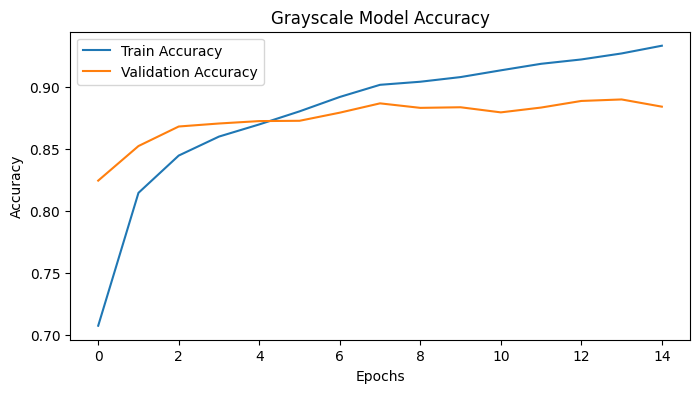

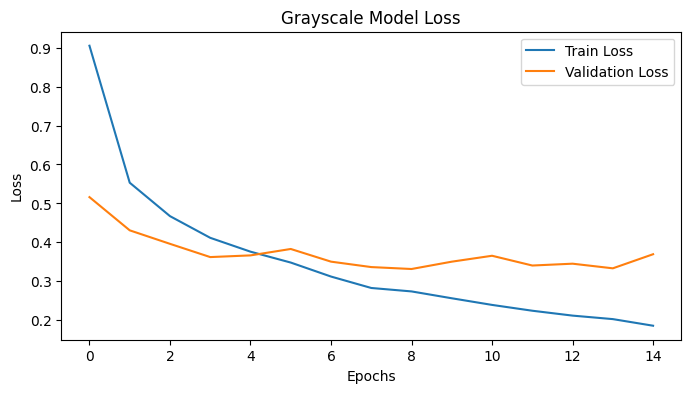

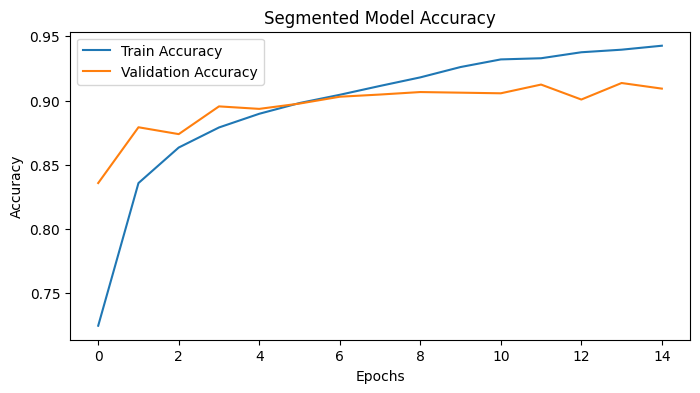

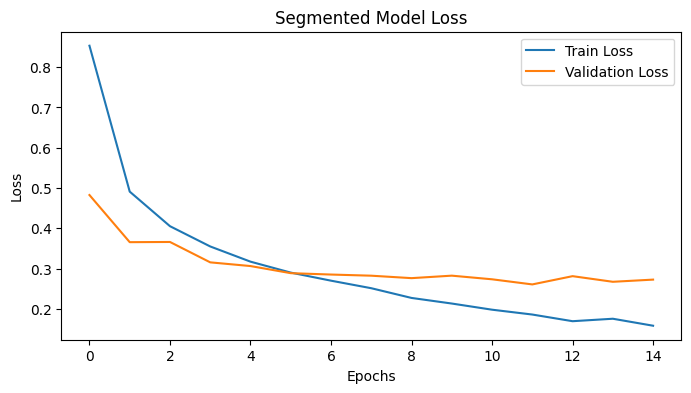

In [15]:
import matplotlib.pyplot as plt

# ====== GRAYSCALE MODEL ======
plt.figure(figsize=(8, 4))
plt.plot(history_gray.history['accuracy'], label='Train Accuracy')
plt.plot(history_gray.history['val_accuracy'], label='Validation Accuracy')
plt.title('Grayscale Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history_gray.history['loss'], label='Train Loss')
plt.plot(history_gray.history['val_loss'], label='Validation Loss')
plt.title('Grayscale Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# ====== SEGMENTED MODEL ======
plt.figure(figsize=(8, 4))
plt.plot(history_seg.history['accuracy'], label='Train Accuracy')
plt.plot(history_seg.history['val_accuracy'], label='Validation Accuracy')
plt.title('Segmented Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history_seg.history['loss'], label='Train Loss')
plt.plot(history_seg.history['val_loss'], label='Validation Loss')
plt.title('Segmented Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
